Sample rate: 48000
Duration (sec): 15.000020833333334
Number of samples: 720001


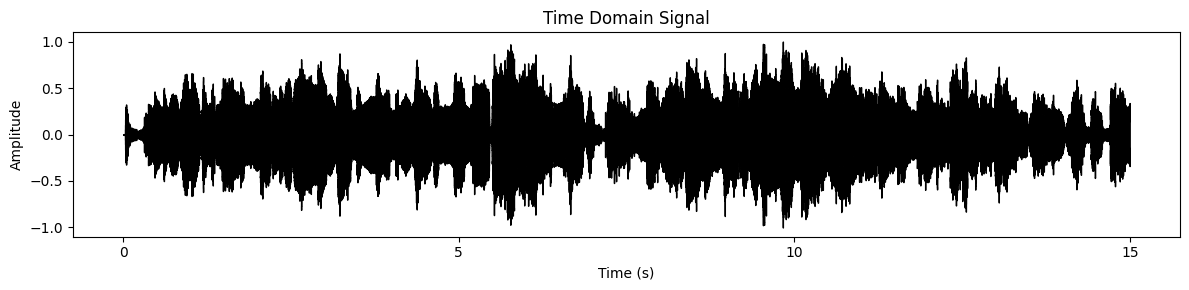

In [4]:


import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch



audio_filepath = os.path.join('/content/song_with_2piccolo.wav')


audio, sr = librosa.load(audio_filepath, sr=None, mono=True)




print("Sample rate:", sr)
print("Duration (sec):", len(audio)/sr)
print("Number of samples:", len(audio))


plt.figure(figsize=(12, 3))
librosa.display.waveshow(audio, sr=sr, color='black')
plt.title('Time Domain Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

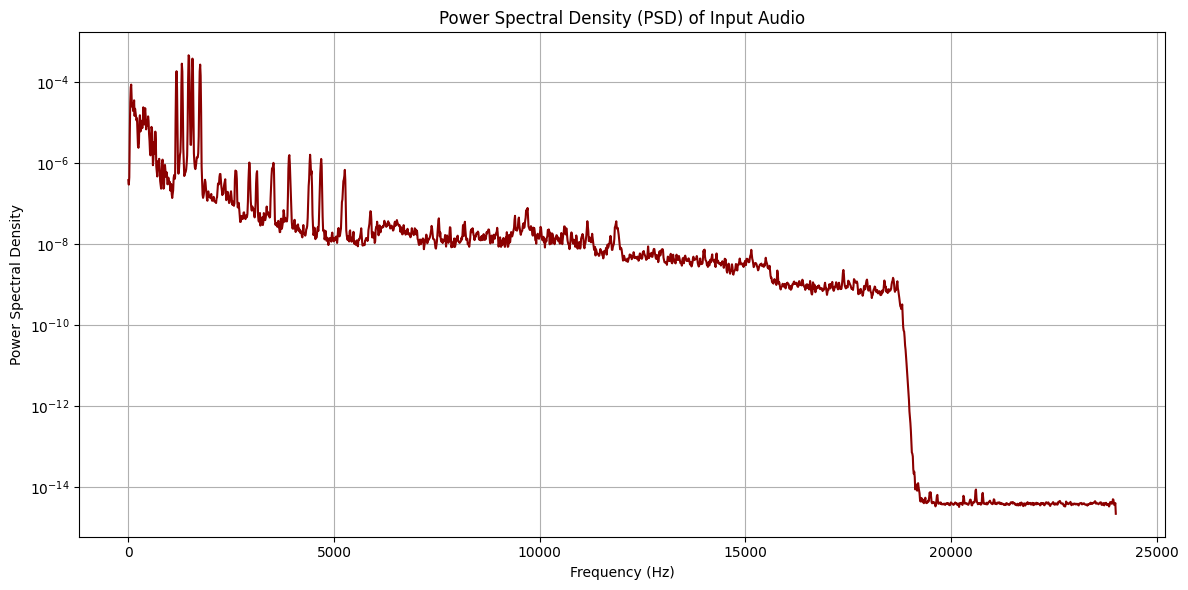

In [5]:
frequencies, psd = welch(audio, fs=sr, nperseg=4096)

plt.figure(figsize=(12, 6))
plt.semilogy(frequencies, psd, color='darkred')
plt.title("Power Spectral Density (PSD) of Input Audio")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.grid(True)
plt.tight_layout()
plt.show()

To precisely identify piccolo’s frequency band:

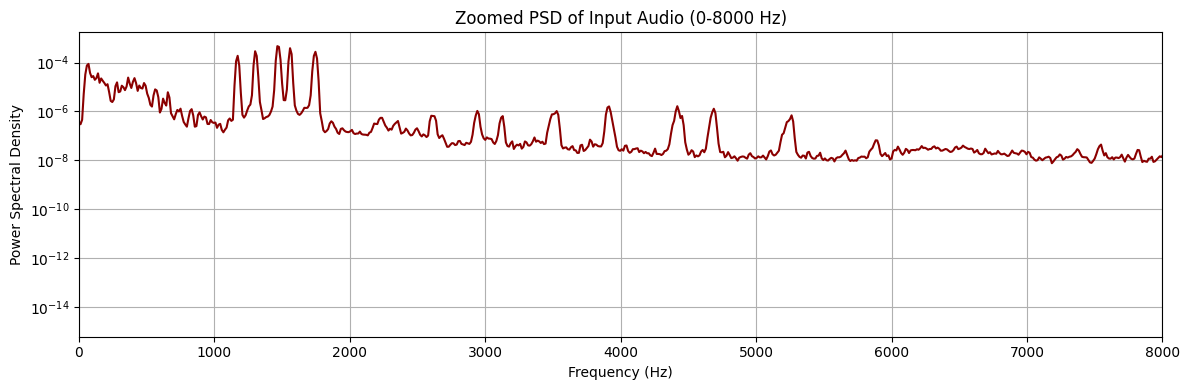

In [6]:
plt.figure(figsize=(12, 4))
plt.semilogy(frequencies, psd, color='darkred')
plt.title("Zoomed PSD of Input Audio (0-8000 Hz)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.xlim(0, 8000)
plt.grid(True)
plt.tight_layout()
plt.show()

Analysis of Zoomed PSD:
The piccolo (unwanted solo instrument) typically lies within high midrange: ~2500 Hz – 4500 Hz.

There are prominent spikes around 3 kHz, 3.5 kHz, and 4 kHz.

These sharp peaks are typical of high-pitched, steady tones (like piccolo notes).

Below 2 kHz:

There is strong energy, but this is expected for vocals, drums, bass, and other musical elements you want to keep.



Band-Stop Filter

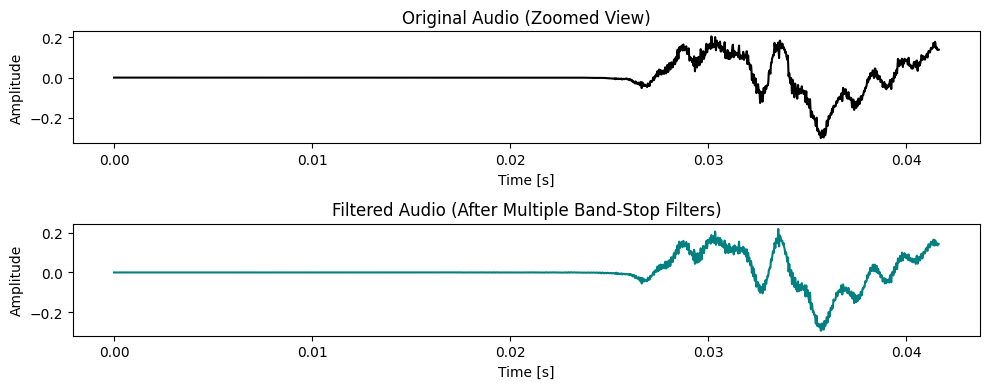

In [7]:
from scipy.signal import butter, sosfiltfilt, sosfreqz


def design_bandstop(center_freq, bandwidth, fs, order=4):
    nyq = fs / 2
    low = (center_freq - bandwidth / 2) / nyq
    high = (center_freq + bandwidth / 2) / nyq
    sos = butter(order, [low, high], btype='bandstop', output='sos')
    return sos

t = np.linspace(0, len(audio) / sr, len(audio))
target_freqs = [1200,1500,1800,2000,2500,3000,3300,3800,4500,4800,5200]
bandwidth = 500

filtered_audio = audio.copy()

for freq in target_freqs:
    sos = design_bandstop(freq, bandwidth, sr, order=4)
    filtered_audio = sosfiltfilt(sos, filtered_audio)

bandwidth2 = 250
target_freqs_2 = [4400, 4750, 5100,5500, 5800,6000,3600]
for freq in target_freqs_2:
    sos = design_bandstop(freq, bandwidth2, sr, order=4)
    filtered_audio = sosfiltfilt(sos, filtered_audio)

bandwidth3 = 50
target_freqs_3 = [3150,7750,7800,]

for freq in target_freqs_3:
    sos = design_bandstop(freq, bandwidth3, sr, order=4)
    filtered_audio = sosfiltfilt(sos, filtered_audio)

bandwidth4 = 150
target_freqs_4 = [1200,8700,7000,7200,7350,7550,7700,6250,6450]

for freq in target_freqs_4:
    sos = design_bandstop(freq, bandwidth4, sr, order=4)
    filtered_audio = sosfiltfilt(sos, filtered_audio)






plt.figure(figsize=(10, 4))
plt.subplot(2, 1, 1)
plt.plot(t[:2000], audio[:2000], color='black')
plt.title("Original Audio (Zoomed View)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")

plt.subplot(2, 1, 2)
plt.plot(t[:2000], filtered_audio[:2000], color='teal')
plt.title("Filtered Audio (After Multiple Band-Stop Filters)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

In [8]:
def plot_spectrogram(signal, sr, title):
    plt.figure(figsize=(20, 16))
    S = librosa.stft(signal, n_fft=2048, hop_length=512)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    librosa.display.specshow(S_db, sr=sr, hop_length=512, x_axis='time', y_axis='hz', cmap='magma')
    plt.colorbar(format="%+2.0f dB")
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Frequency [Hz]")
    max_freq = sr // 2
    yticks = np.arange(0, max_freq + 1, 1000)
    plt.yticks(yticks, fontsize=14)
    plt.xticks(fontsize=14)
    plt.tight_layout()
    plt.show()

plot_spectrogram(audio, sr, "Spectrogram of Original Audio")
plot_spectrogram(filtered_audio, sr, "Spectrogram After Band-Stop Filtering")



Output hidden; open in https://colab.research.google.com to view.

audio

In [9]:

from IPython.display import Audio
Audio(filtered_audio, rate=sr)

bode and pole-zero plots

/tmp/ipython-input-10-3242653041.py:18: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w, 20 * np.log10(np.abs(h)), 'b')


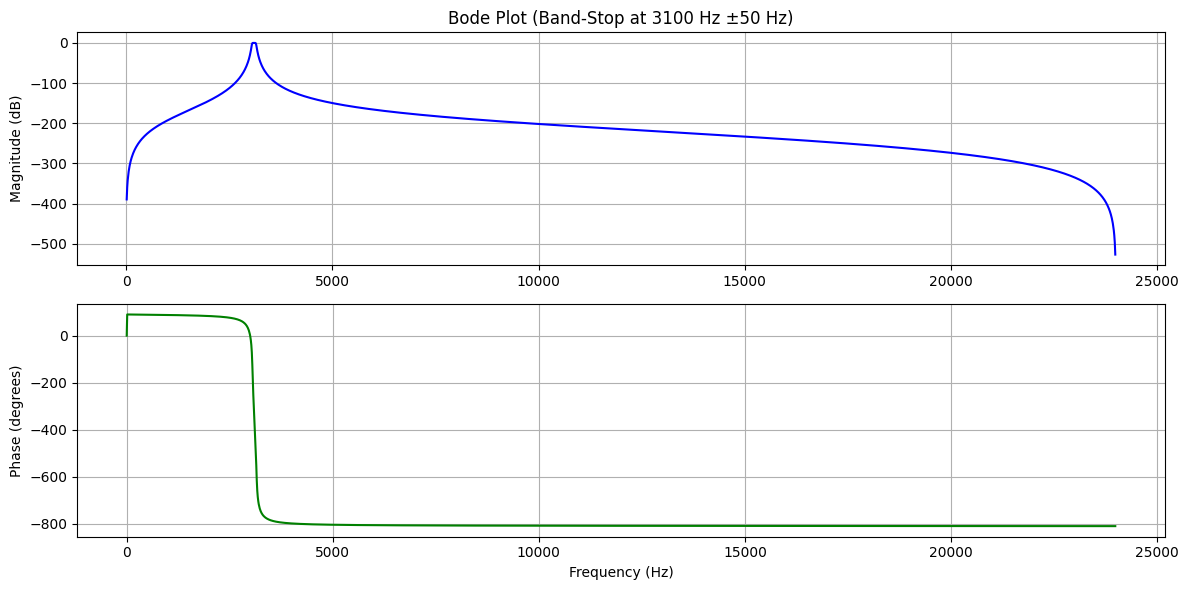

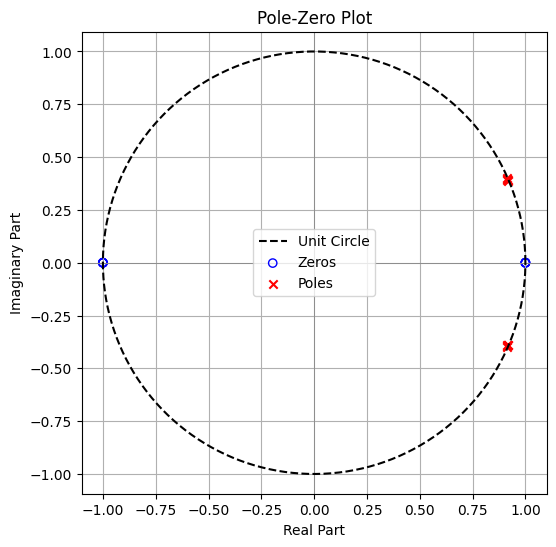

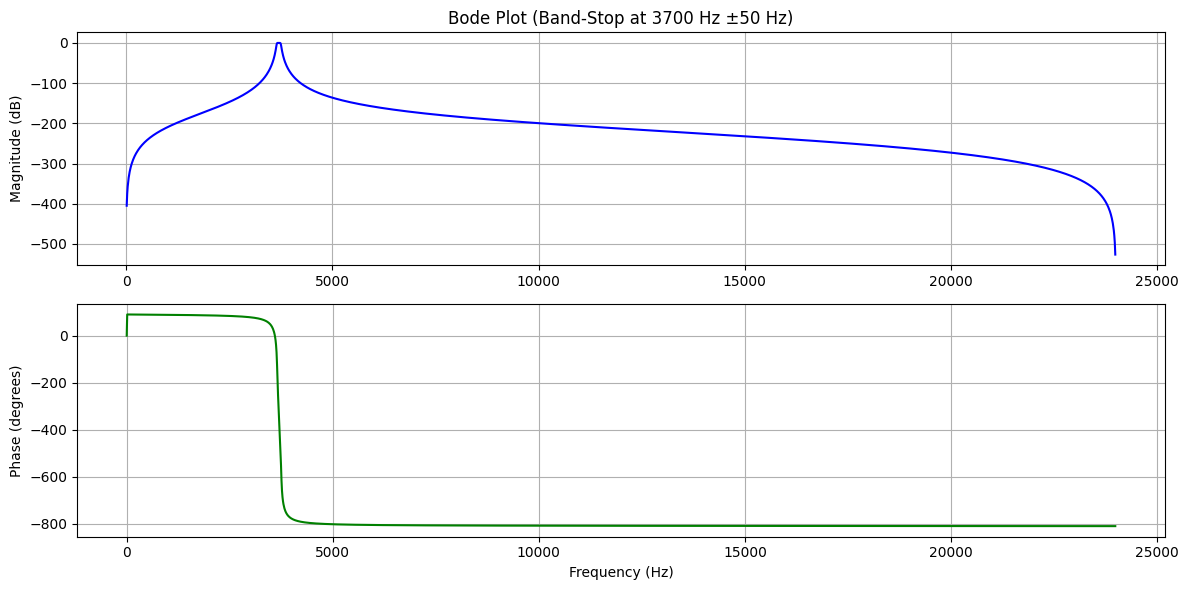

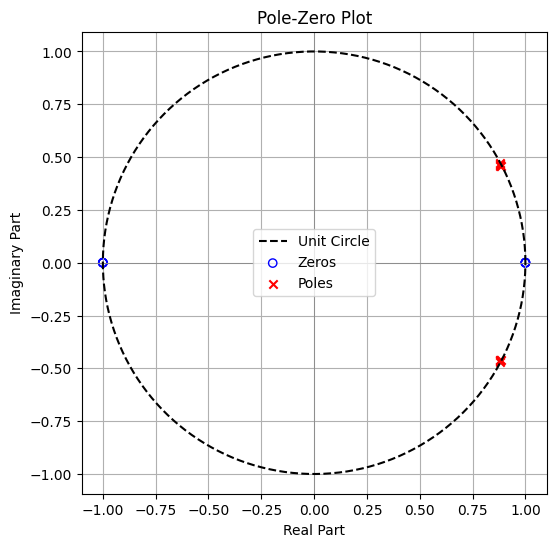

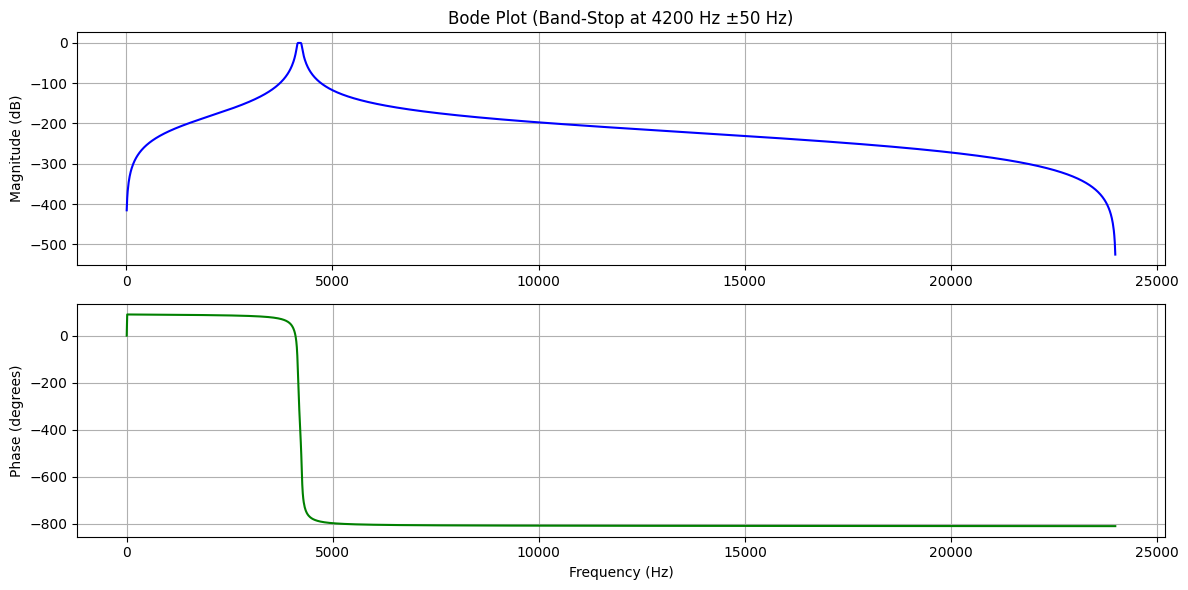

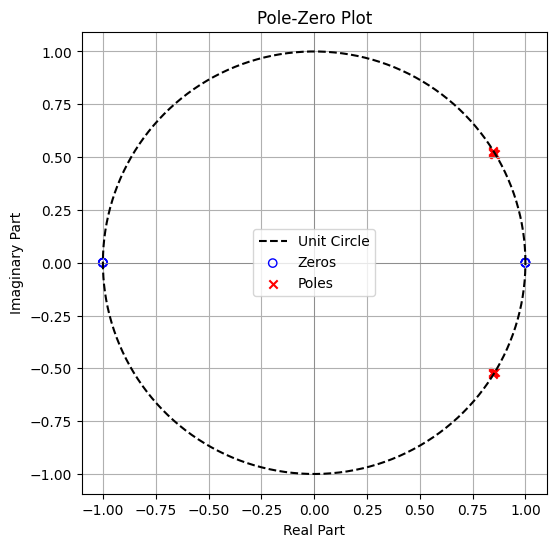

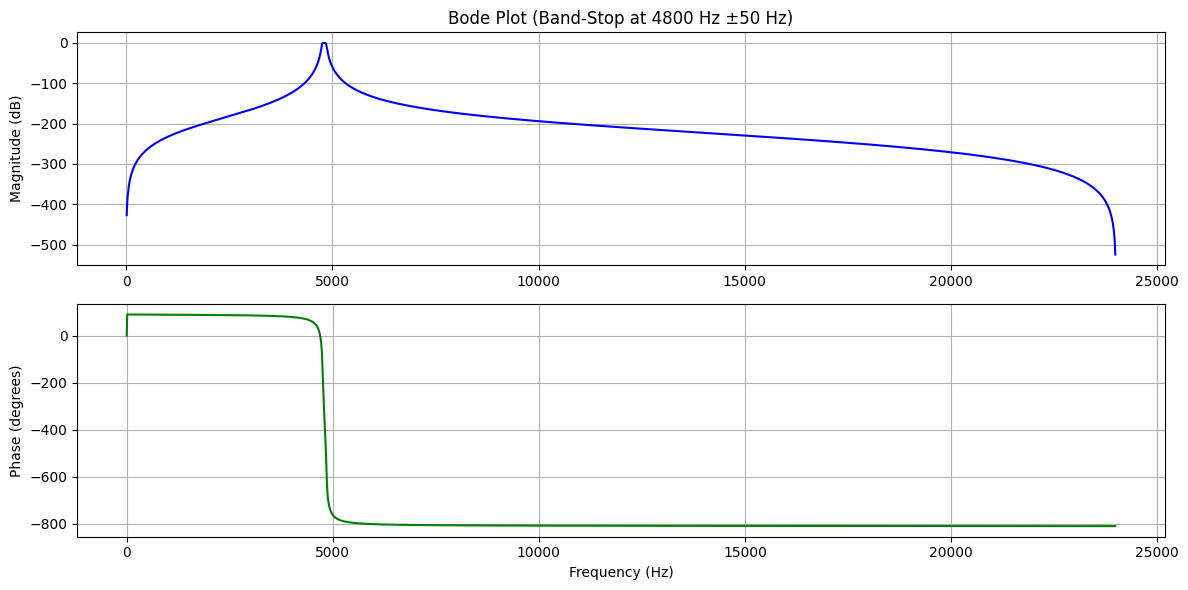

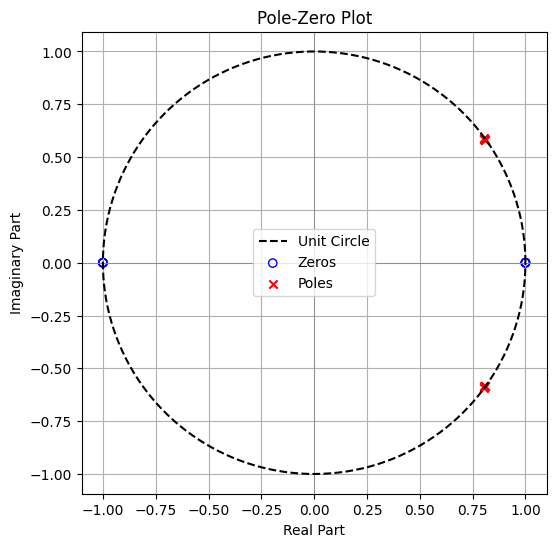

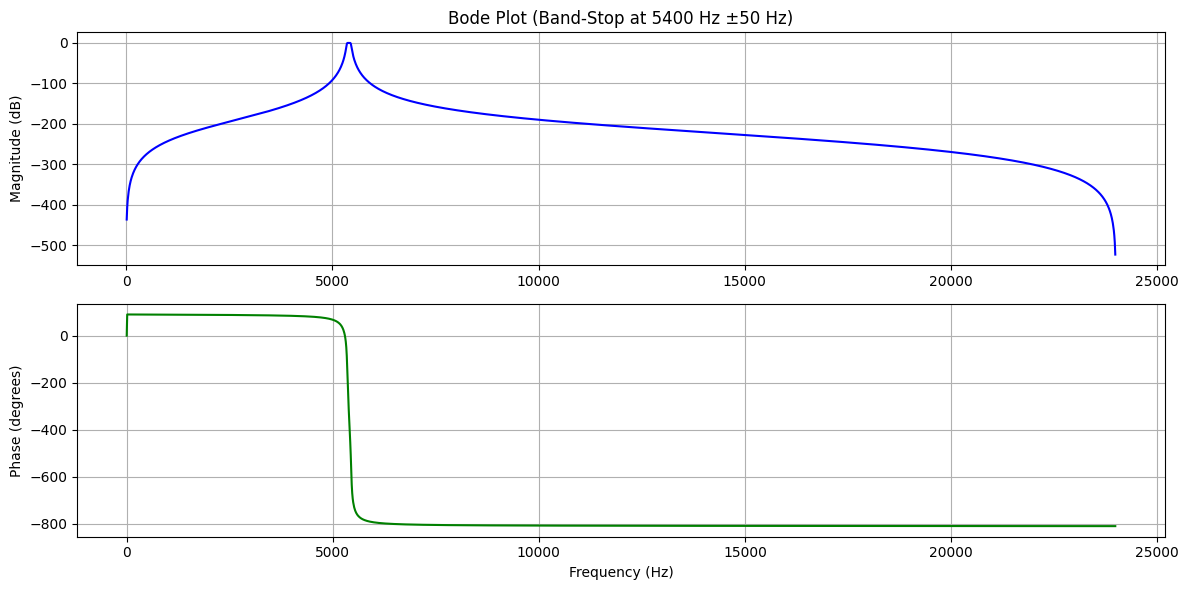

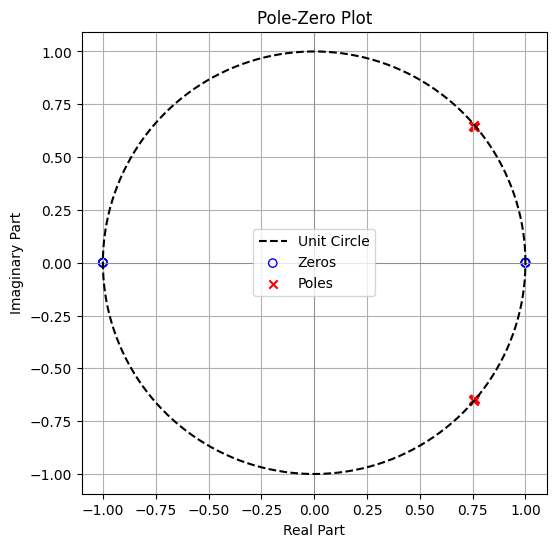

In [10]:
from scipy.signal import sos2tf, tf2zpk

target_freqs = [3100, 3700, 4200, 4800, 5400]
bandwidth = 100

nyq = sr / 2
order = 5

for center_freq in target_freqs:
    low = (center_freq - bandwidth / 2) / nyq
    high = (center_freq + bandwidth / 2) / nyq
    sos = butter(order, [low, high], btype='bandpass', output='sos')

    w, h = sosfreqz(sos, worN=2000, fs=sr)

    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(w, 20 * np.log10(np.abs(h)), 'b')
    plt.title(f'Bode Plot (Band-Stop at {center_freq} Hz ±{bandwidth//2} Hz)')
    plt.ylabel('Magnitude (dB)')
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(w, np.unwrap(np.angle(h)) * 180 / np.pi, 'g')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Phase (degrees)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()



    title="Pole-Zero Plot"
    b, a = sos2tf(sos)
    z, p, k = tf2zpk(b, a)

    plt.figure(figsize=(6, 6))
    plt.axhline(0, color='gray', lw=0.5)
    plt.axvline(0, color='gray', lw=0.5)

    theta = np.linspace(0, 2*np.pi, 512)
    plt.plot(np.cos(theta), np.sin(theta), 'k--', label='Unit Circle')


    plt.scatter(np.real(z), np.imag(z), marker='o', facecolors='none', edgecolors='b', label='Zeros')
    plt.scatter(np.real(p), np.imag(p), marker='x', color='r', label='Poles')
    plt.title(title)
    plt.xlabel('Real Part')
    plt.ylabel('Imaginary Part')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()

Comparing the frequency response of the input audio and the filtered audio

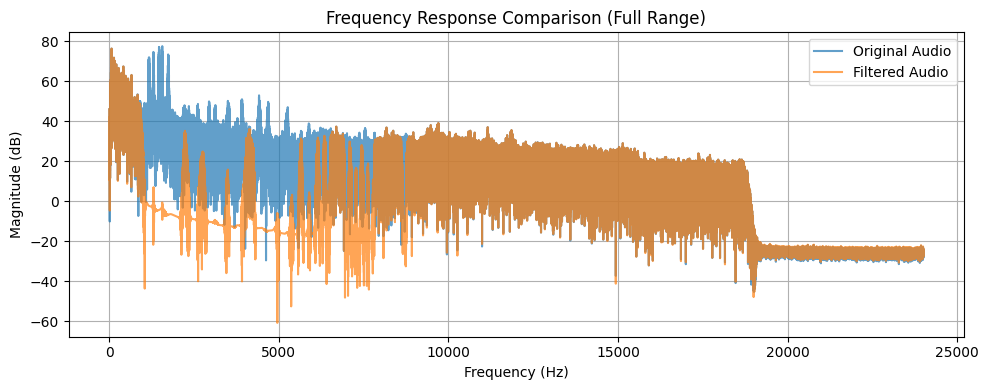

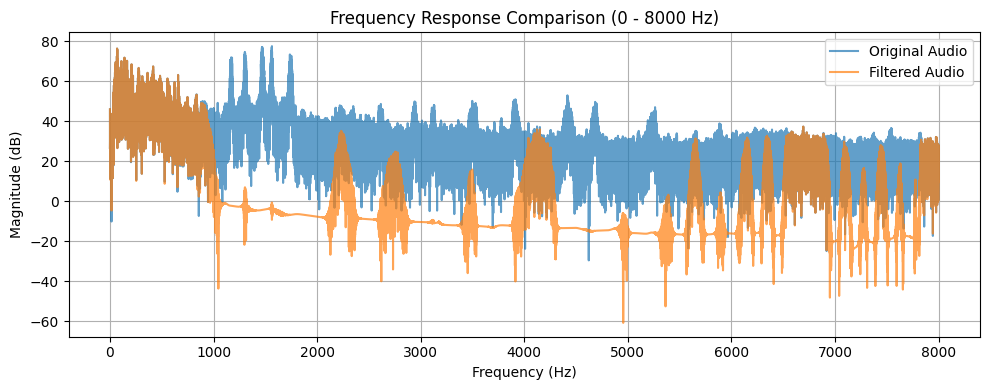

In [11]:


def plot_frequency_response_comparison(original_audio, filtered_audio, sr, zoom_max=None):

    N = len(original_audio)
    freqs = np.fft.rfftfreq(N, d=1/sr)

    original_fft = np.abs(np.fft.rfft(original_audio))
    filtered_fft = np.abs(np.fft.rfft(filtered_audio))


    original_db = 20 * np.log10(original_fft )
    filtered_db = 20 * np.log10(filtered_fft )

    plt.figure(figsize=(10, 4))
    plt.plot(freqs, original_db, label="Original Audio", alpha=0.7)
    plt.plot(freqs, filtered_db, label="Filtered Audio", alpha=0.7)
    plt.title("Frequency Response Comparison (Full Range)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    if zoom_max:
        plt.figure(figsize=(10, 4))
        zoom_indices = freqs <= zoom_max
        plt.plot(freqs[zoom_indices], original_db[zoom_indices], label="Original Audio", alpha=0.7)
        plt.plot(freqs[zoom_indices], filtered_db[zoom_indices], label="Filtered Audio", alpha=0.7)
        plt.title(f"Frequency Response Comparison (0 - {zoom_max} Hz)")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Magnitude (dB)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


plot_frequency_response_comparison(audio, filtered_audio, sr, zoom_max=8000)
